In [1]:
import os
java_home = os.environ.get('JAVA_HOME', None)
java_path = '/Library/Java/JavaVirtualMachines/adoptopenjdk-11.jdk/Contents/Home/bin'
os.environ['JAVA_HOME'] = java_path

In [2]:
import javabridge
import bioformats
import matplotlib.pyplot as plt
import numpy as np
javabridge.start_vm(class_path=bioformats.JARS)
from skimage.io import imread,imsave
import scipy.signal as ss
from skimage import measure
from matplotlib.path import Path
import pandas as pd
import seaborn as sns
from pywavesurfer import ws
from glob import glob
import os

In [3]:
coordinates = []
for r in range(512):
    for c in range(512):
        coordinates.append([r,c])
coordinates = np.array(coordinates)

In [4]:
# construct_info = {
# 'Dish_1': '633.6391',
# 'Dish_2': '633.2217',
# 'Dish_3': '633.2392',
# 'Dish_4': '633.2376',
# 'Dish_5': '633.6412',
# 'Dish_6': '633.2185'
# }

construct_info = {
'Dish_1': 'test',
}


/Users/zhengj10/Desktop/test/230207_Plate_005_556.857_FOV_00001.tif


<Figure size 576x576 with 0 Axes>

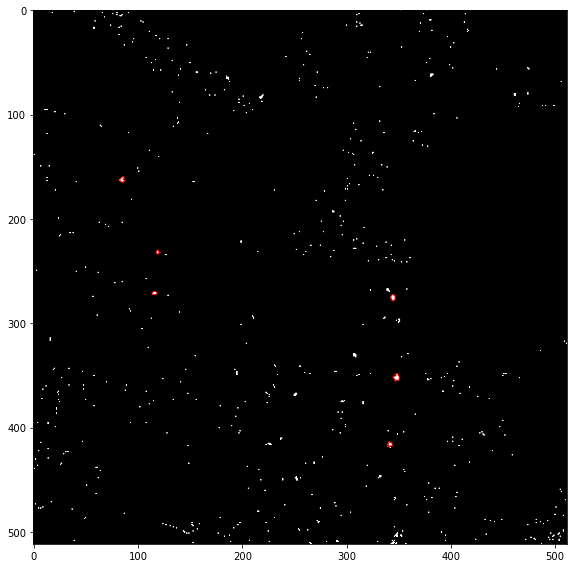

/Users/zhengj10/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/var/folders/87/trl8ql4s7vj6fkdtrrkcwx6s0zb2d2/T/ipykernel_59573/1541294022.py:69: RuntimeWarning: invalid value encountered in double_scalars
  dFF = (F_single - np.sum(rois[roi]*F0)/np.sum(rois[roi]))/(np.sum(rois[roi]*F0)/np.sum(rois[roi])-Fb)


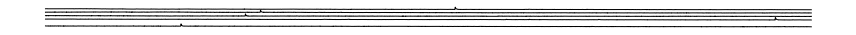

In [6]:
imgPath = '/Users/zhengj10/Desktop'
date = 'test'

Date = []
Plate = []
Construct = []
FOV = []
ROI = []
ROI_no_pixels = []
DFF = []
DFF_hp_filt = []
Peak_idx = []

Img_format = []
Objective = []

imgFiles = glob(os.path.join(imgPath,date)+'/*.tif')
imgFiles = sorted(imgFiles)
h5Files = glob(os.path.join(imgPath,date)+'/*.h5')
h5Files = sorted(h5Files)
for img_no in range(len(imgFiles)):
    imgFile = imgFiles[img_no]
    print(imgFile)

    imgData = imread(imgFile)
    F0 = imgData[0,:,:].astype('float16')
    Fb = np.min(imgData.astype('float16'))
    dFF = (imgData.astype('float16')-F0.astype('float16'))/(F0.astype('float16')-Fb)

    dFF_diff = np.diff(dFF, axis=0)
    plt.figure(figsize=[8,8])
    act_pix = np.max(dFF_diff,axis=0)>0.4
    bg = imgData[-1,:,:]>Fb+500
    act_pix = bg*act_pix
    
    plt.figure(figsize=[8,8])
    plt.imshow(act_pix,cmap='gray',vmax=0.5)
    thre = 16 # Exclude small ROIs
    contours = measure.find_contours(act_pix, 0.5)
    for contour in contours:
        if contour.shape[0]>thre and contour.shape[0]<10*thre:
            plt.plot(contour[:,1], contour[:,0], color = 'r',lw=1)
    plt.tight_layout()
    plt.savefig('/groups/genie/genie/Presentations/Jihong/GENIE data/211028/ROI_seg_sample.png')
    plt.show()


    Fb = np.min(imgData[-1,:,:]).astype('float16')
    F0 = np.mean(imgData[:5,:,:],axis=0).astype('float16')

    rois = []
    for contour in contours:
        if contour.shape[0]>thre and contour.shape[0]<10*thre:
            p = Path(contour)
            roi = p.contains_points(coordinates)
            roi = roi.reshape(512,512)
            rois.append(roi)

    fig = plt.figure(figsize=[12,len(rois)/10])
    y_shift = 1
    x = np.arange(1,imgData.shape[0]+1)
    for roi in range(len(rois)):
        dFF_all = []
        offset = y_shift
        for frame in range(imgData.shape[0]):

            F_single = np.sum(rois[roi]*imgData[frame,:,:])/np.sum(rois[roi])
        #     F_all.append(F_single)
            dFF = (F_single - np.sum(rois[roi]*F0)/np.sum(rois[roi]))/(np.sum(rois[roi]*F0)/np.sum(rois[roi])-Fb)
            dFF_all.append(dFF)  
        dFF_all = np.array(dFF_all)

        b, a = ss.butter(2, 0.002, btype='high')
        dFF_hp_filt = ss.filtfilt(b, a, dFF_all,padlen=None)
        peaks,_ = ss.find_peaks(dFF_hp_filt,height=0.2)
        
        Date.append(date)
        Plate.append(os.path.basename(imgFile).split('_')[1]+'_'+os.path.basename(imgFile).split('_')[2])
        Construct.append(os.path.basename(imgFile).split('_')[3])
        FOV.append(os.path.basename(imgFile).split('_')[-2]+'_'+os.path.basename(imgFile).split('_')[-1])
        ROI.append('roi_'+str(roi+1))
        ROI_no_pixels.append(np.sum(rois[roi]))
        DFF.append(dFF_all)
        DFF_hp_filt.append(dFF_hp_filt)
        Peak_idx.append(peaks)
        Img_format.append('.tif converted from .dcimg')
        Objective.append('63x oil N/A: 1,4')

        plt.fill_between(x,dFF_all - offset, 0 - offset, zorder=y_shift+1, facecolor='w', edgecolor='w', lw=0, 
                         closed=True)
        plt.plot(x,dFF_all - offset,zorder=y_shift+1, color='k', lw=1)
#         plt.scatter(peaks,dFF_all[peaks] - offset,color='m')
        plt.axis('off')
        y_shift+=1            
    plt.tight_layout()
    plt.show()
    plt.close()

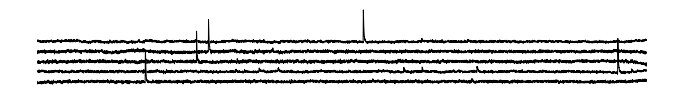

In [32]:
y_shift = 0
fig = plt.figure(figsize=[12,len(rois)/4])
for i in DFF_hp_filt:
    if isNaN(np.mean(i)):
        continue
    offset = y_shift/5
    plt.fill_between(x,i - offset, 0 - offset, zorder=y_shift+1, facecolor='w', edgecolor='w', lw=0, 
                         closed=True)
    plt.plot(x,i- offset,zorder=y_shift+1, color='k', lw=1)
#     plt.scatter(peaks,dFF_all[peaks] - offset,color='m')
    plt.axis('off')
    y_shift+=1            

In [23]:
def isNaN(A):
    return A!=A

True

In [18]:
# DFF_hp_filt[5].shape
DFF_hp_filt[4]

array([nan, nan, nan, ..., nan, nan, nan])

In [ ]:
b, a = ss.butter(2, 0.002, btype='high')
dFF_med_hp_filt = ss.filtfilt(b, a, dFF_all_med,padlen=None)

In [ ]:
plt.plot(dFF_med_hp_filt)
# plt.plot(dFF_all)

In [ ]:
plt.imshow(imgData_m,cmap='gray')
# imgData_m = np.mean(imgData,axis=0)

In [ ]:
df_new = pd.DataFrame({'Date':Date,'Plate':Plate,'Construct':Construct,'FOV':FOV,'ROI':ROI,'ROI_no_pixels':ROI_no_pixels,
                   'DFF':DFF,'DFF_med':DFF_med,'DFF_med_hp_filt':DFF_med_hp_filt,'Peak_idx':Peak_idx,
                   'Img_format':Img_format,'Objective':Objective})
df_new.shape

In [ ]:
df = pd.read_pickle(imgPath+'/summary.pkl')
df.shape

In [ ]:
df.Date.unique()

In [ ]:
df = df.append(df_new,ignore_index=True)
df.shape

In [ ]:
df.to_pickle(imgPath+'/summary.pkl')

### Plot processed data

In [ ]:
imgPath = '/groups/genie/genie/Jihong_GENIE_stuff/iGluSnFR_spontaneous_activity'

In [ ]:
df

In [ ]:
Fb = np.min(imgData[-1,:,:]).astype('float16')
F0 = np.mean(imgData[:5,:,:],axis=0).astype('float16')

rois = []
for contour in contours:
    if contour.shape[0]>thre:
        p = Path(contour)
        roi = p.contains_points(coordinates)
        roi = roi.reshape(512,512)
        rois.append(roi)
fig = plt.figure(figsize=[12,1.5])
fig = plt.figure(figsize=[12,len(rois)/10])
i = 1
x = np.arange(1,3001)
# for roi in range(len(rois)):
for roi in range(5):
    print(roi)

    dFF_all = []
    # F_all = []
    offset = i
    for frame in range(imgData.shape[0]):
        
        F_single = np.sum(rois[roi]*imgData[frame,:,:])/np.sum(rois[roi])
    #     F_all.append(F_single)
        dFF = (F_single - np.sum(rois[roi]*F0)/np.sum(rois[roi]))/(np.sum(rois[roi]*F0)/np.sum(rois[roi])-Fb)
        dFF_all.append(dFF)  
    dFF_all = np.array(dFF_all)
    dFF_all = ss.medfilt(dFF_all,kernel_size=5)
    
    b, a = ss.butter(2, 0.01, btype='high')
    dFF_all_filt = ss.filtfilt(b, a, dFF_all,padlen=None)
    peaks,_ = ss.find_peaks(dFF_all_filt,height=0.2)
    
    plt.fill_between(x,dFF_all - offset, 0 - offset, zorder=i+1, facecolor='w', edgecolor='w', lw=0, closed=True)
    plt.plot(x,dFF_all - offset,zorder=i+1, color='k', lw=1)
    plt.scatter(peaks,dFF_all[peaks] - offset,color='m')
    # plt.axis('off')
    i+=1  
    plt.axis('off')
plt.tight_layout()
# fig.savefig(imgPath+'roi.png')
plt.show()

In [ ]:
ss.medfilt?

In [ ]:
plt.figure(figsize=[15,4])
plt.plot(dFF_all)
plt.scatter(peaks,dFF_all[peaks],color='m')

In [ ]:
plt.plot(np.diff(dFF_all))

In [ ]:
peaks

In [ ]:
peaks

In [ ]:
plt.plot(dFF_all_filt)
plt.scatter(peaks,dFF_all[peaks],color='m')

In [ ]:
b, a = ss.butter(2, 0.005, btype='high')
dFF_all_filt = ss.filtfilt(b, a, dFF_all,padlen=None)

In [ ]:
plt.figure(figsize=[15,1])
plt.plot(dFF_all_filt)
# plt.plot(dFF_all)
plt.tight_layout()
plt.show()

In [ ]:
ss.filtfilt?

In [ ]:
dFF_all_detrend = ss.detrend(dFF_all,axis=0,type='linear')

In [ ]:
from scipy.signal import butter, lfilter


def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y


# if __name__ == "__main__":
#     import numpy as np
#     import matplotlib.pyplot as plt
#     from scipy.signal import freqz

#     # Sample rate and desired cutoff frequencies (in Hz).
#     fs = 5000.0
#     lowcut = 500.0
#     highcut = 1250.0

#     # Plot the frequency response for a few different orders.
#     plt.figure(1)
#     plt.clf()
#     for order in [3, 6, 9]:
#         b, a = butter_bandpass(lowcut, highcut, fs, order=order)
#         w, h = freqz(b, a, worN=2000)
#         plt.plot((fs * 0.5 / np.pi) * w, abs(h), label="order = %d" % order)

#     plt.plot([0, 0.5 * fs], [np.sqrt(0.5), np.sqrt(0.5)],
#              '--', label='sqrt(0.5)')
#     plt.xlabel('Frequency (Hz)')
#     plt.ylabel('Gain')
#     plt.grid(True)
#     plt.legend(loc='best')

#     # Filter a noisy signal.
#     T = 0.05
#     nsamples = int(T * fs)
#     t = np.linspace(0, T, nsamples, endpoint=False)
#     a = 0.02
#     f0 = 600.0
#     x = 0.1 * np.sin(2 * np.pi * 1.2 * np.sqrt(t))
#     x += 0.01 * np.cos(2 * np.pi * 312 * t + 0.1)
#     x += a * np.cos(2 * np.pi * f0 * t + .11)
#     x += 0.03 * np.cos(2 * np.pi * 2000 * t)
#     plt.figure(2)
#     plt.clf()
#     plt.plot(t, x, label='Noisy signal')

#     y = butter_bandpass_filter(x, lowcut, highcut, fs, order=6)
#     plt.plot(t, y, label='Filtered signal (%g Hz)' % f0)
#     plt.xlabel('time (seconds)')
#     plt.hlines([-a, a], 0, T, linestyles='--')
#     plt.grid(True)
#     plt.axis('tight')
#     plt.legend(loc='upper left')

#     plt.show()

In [ ]:
fs = 100.0
lowcut = 
highcut = 1.0

y = butter_bandpass_filter(dFF_all, lowcut, highcut, fs, order=2)

In [ ]:
# dFF_all = ss.detrend(dFF_all)
plt.plot(y)

In [ ]:
butter?

In [ ]:
# imsave('/Users/zhengj10/Desktop/B_med.tiff',B_med)
imsave('/Users/zhengj10/Desktop/dFF_B_med_diff.tiff', dFF_B_med_diff)

In [ ]:
np.max(dFF_B_med_diff)

In [ ]:
# B_diff_max = np.max(B_diff,axis=0)

In [ ]:
plt.figure(figsize=[12,12])
ax = plt.subplot(111)
ax.imshow(A.read(rescale=False),cmap='gray',vmax=10000)
ax.axis('off')
plt.show()

In [ ]:
bioformats.load_image?

In [ ]:
C = bioformats.get_omexml_metadata(imgFile)

In [ ]:
o = bioformats.OMEXML(C)

In [ ]:
D = o.image()

In [ ]:
print(D.Name)

In [ ]:
D.get_AcquisitionDate()

In [ ]:
# C